In [15]:
import snap
import numpy as np
from matplotlib import pyplot as plt
import utils as ut
import networkx as nx
from math import ceil
from wordcloud import WordCloud, ImageColorGenerator
import collections
from PIL import Image

np.random.seed(42)

In [5]:
# Load graphs and edge weights
OCN, OW = ut.load_ocn()
FPH, FW = ut.load_fph()
UCN, UW = ut.load_ucn()
SN, SW = ut.load_sn()
IFG, IRG, Mappings = ut.load_basic_graphs()
IIds = [NI.GetId() for NI in UCN.Nodes()]
iid_to_ingredient = Mappings['IID_to_Ingredient_Mapping']
ingredient_to_iid = {ingredient:iid for iid, ingredient in iid_to_ingredient.iteritems()}
RawCounts = sorted([(len(ut.get_common_neighbors(IRG, AIId, BIId)[0]),(AIId, BIId)) for i, AIId in enumerate(IIds[:-1]) for BIId in IIds[i+1:]], reverse=True)
RawCountsDict = {Edge:Count for Count, Edge in RawCounts}

In [94]:
##############################################
########## Network Analysis Tools ############
##############################################

# Plot a degree distribution histogram
def hist_degree_distribution(G, name):
    filename = '../analysis/' + name + '_DegDistrHist'
    description = name + ': Degree Distribution Histogram'
    Histogram = [NI.GetDeg() for NI in G.Nodes()]
    plt.xlabel('Node Degree')
    plt.ylabel('Number of Nodes with a Given Degree')
    plt.hist(Histogram)
    plt.savefig(filename)
    plt.show()

# Plot the degree distribution of a complement network
def plot_degree_distribution(G, name):
    filename = '../analysis/' + name + '_DegDistr'
    description = name + ': Degree Distribution'
    X, Y = [], []
    DegToCntV = snap.TIntPrV()
    snap.GetOutDegCnt(G, DegToCntV)
    for item in DegToCntV:
        X.append(item.GetVal1())
        Y.append(item.GetVal2())
    plt.xlabel('Node Degree')
    plt.ylabel('Number of Nodes with a Given Degree')
    plt.title(description)
    plt.plot(X, Y, 'ro')
    plt.savefig(filename)
    plt.show()
    
# Print the clustering coefficient of a complement network
def clustering_coefficient(G):
    DegToCCfV = snap.TFltPrV()
    Result = snap.GetClustCfAll(G, DegToCCfV, -1)
    print 'Average Clustering Coefficient:', Result[0]

# Get the Top K Edge Weights of a complement network
def print_top_w(W, K, iid_to_ingredient, Reverse=True):
    OrderedWeights = sorted([(Weight, Edge) for Edge, Weight in W.iteritems()], reverse=Reverse)[:K]
    for i, (Weight, Edge) in enumerate(OrderedWeights):
        pairing = '{}. {},{} ({:.5f})'.format(i+1, iid_to_ingredient[Edge[0]], iid_to_ingredient[Edge[1]], Weight)
        print pairing
        
# Get random set of node pairs lacking an edge
def print_no_edge_pairs(G, K):
    NoEdges = []
    NIds = [NI.GetId() for NI in G.Nodes()]
    for i, ANId in enumerate(NIds[:-1]):
        for BNId in NIds[i+1:]:
            if not G.IsEdge(ANId, BNId):
                NoEdges.append((ANId, BNId))
    NoEdges = [NoEdges[i] for i in np.random.choice(range(len(NoEdges)), K)]
    for Edge in NoEdges:
        pair = '{},{}'.format(iid_to_ingredient[Edge[0]], iid_to_ingredient[Edge[1]])
        print pair

# Get the top K ingredients by page rank
def print_top_pr(G, K, iid_to_ingredient, Reverse=True):
    print 'PageRank:'
    PRankH = snap.TIntFltH()
    snap.GetPageRank(G, PRankH)
    PageRank = sorted([(PRankH[item], item) for item in PRankH], reverse=Reverse)
    for Rank, IId in PageRank[:K]:
        print '{}: {:.5f}'.format(iid_to_ingredient[IId], Rank)

# Get the communities in the graph
def get_communities(G):
    CmtyV = snap.TCnComV()
    modularity = snap.CommunityCNM(G, CmtyV)
    return [[IId for IId in Community] for Community in CmtyV], modularity

# Get a community for a given ingredient
def get_community_of_ingredient(Communities, IId):
    for C in Communities:
        if IId in C: return C
    return None
    
# Draw a full graph
def draw_graph(G, Communities, iid_to_ingredient):
    NG = nx.Graph()
    for NI in G.Nodes(): NG.add_node(NI.GetId())
    for EI in G.Edges(): NG.add_edge(EI.GetSrcNId(), EI.GetDstNId())
    print 'Kamada Kawai Graph Drawing'
    plt.figure(1)
#     nx.draw_kamada_kawai(NG)
    nx.draw(NG)
    plt.show()
#     print 'Spectral Graph Drawing'
#     plt.figure(2)
#     nx.draw_spectral(NG)
#     plt.show()
    pass

# Graph a word cloud for each community based on edge weight
def community_word_cloud(Communities, W, key_ingredient, name):
    # Get the community containing the key ingredient
    Community = []
    for C in Communities:
        if ingredient_to_iid[key_ingredient] in C:
            Community = C
            break
    # Create dictionary of words to sum of edge weights
    MinWeight = min([Weight for Edge, Weight in W.iteritems()])
    PowerDict = collections.defaultdict(int)
    for IId in Community:
        for Edge, Weight in W.iteritems():
            if Edge[0] == IId or Edge[1] == IId:
                PowerDict[IId] += (Weight - MinWeight)
    # Create a word list by dividing the power by the min power, taking the ceil, and adding that many words to the list
    WordList = []
    for IId, Power in PowerDict.iteritems():
        NumWords = int(ceil(Power))
        NewWords = [iid_to_ingredient[IId]] * NumWords
        WordList = WordList + NewWords
    # Graph the word cloud
    text = ' '.join(WordList)
    mask = np.array(Image.open("../analysis/color_wheel_mask.png"))
    wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", mask=mask, max_words=2000, max_font_size=75, stopwords=[], collocations = False, width=1000, height=1000, margin=0).generate(text)
    # Create coloring from image
    image_colors = ImageColorGenerator(mask)
    wordcloud.recolor(color_func=image_colors)
    wordcloud.to_file('../analysis/{}_wordcloud.png'.format(name))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

# Network Analysis of G with weights W
def analyze_network(G, W, name):
    hist_degree_distribution(G, name)
    plot_degree_distribution(G, name)
    clustering_coefficient(G)
    print_no_edge_pairs(G, 10)
    print_top_pr(G, 10, Mappings['IID_to_Ingredient_Mapping'])
    Communities, Modularity = get_communities(G)
#     print 'Communities:'
#     for C in Communities: print [iid_to_ingredient[IId] for IId in C]
#     print '\n'
#     draw_graph(G, Communities, Mappings['IID_to_Ingredient_Mapping'])
    if name == 'SN':
        community_word_cloud(Communities, W, 'egg', name + '_egg')
        community_word_cloud(Communities, W, 'black_pepper', name + '_black_pepper')
    else:
        community_word_cloud(Communities, W, 'egg', name)

# Analyze the ingredients in terms of 1. Common Recipes 2. FPHF 3.  4. PMI
def analyze_ingredients(TopK, LowK, RecipeThreshold):
    iid_to_ingredient = Mappings['IID_to_Ingredient_Mapping']
    # Analyze Raw Counts
    print 'Raw Counts:'
    for Count, Edge in RawCounts[:TopK]:
        print '{}, {}: {}'.format(iid_to_ingredient[Edge[0]], iid_to_ingredient[Edge[1]], Count)
    print '\n'
    # Analyze FPHF
    print 'FPHF Top Scores:'
    print_top_w(FW, TopK, iid_to_ingredient, Reverse=True)
    print '\n'
    print 'FPHF Low Scores:'
    print_top_w(FW, LowK, iid_to_ingredient, Reverse=False)
    print '\n'
    print 'COF Top Scores:'
    print_top_w(UW, TopK, iid_to_ingredient, Reverse=True)
    print '\n'
    print 'COF Low Scores:'
    print_top_w(UW, LowK, iid_to_ingredient, Reverse=False)
    print '\n'
    print 'SN Top Scores:'
    print_top_w(SW, TopK, iid_to_ingredient, Reverse=True)
    print '\n'
    print 'SN Low Scores:'
    print_top_w(SW, LowK, iid_to_ingredient, Reverse=False)
    print '\n'
    print 'PMI Top Scores:'
    print_top_w(OW, TopK, iid_to_ingredient, Reverse=True)
    print '\n'
    print 'PMI Low Scores:'
    print_top_w(OW, LowK, iid_to_ingredient, Reverse=False)

In [95]:
###############################################
########## Main Analysis Execution ############
###############################################

def analysis():
    print '###############################################\n################# Analysis ####################\n###############################################'
    # Original Complement Network Analysis
    print 'Original Complement Network Analysis:\n'
    analyze_network(OCN, OW, 'OCN')
    print '\n'
    # Food Pairing Hypothesis Network Analysis
    print 'Food Pairing Hypothesis Network Analysis:\n'
    analyze_network(FPH, FW, 'FPH')
    print '\n'
    # Updated Complement Network Analysis
    print 'Updated Complement Network Analysis:\n'
    analyze_network(UCN, UW, 'UCN')
    print '\n'
    # Substitution Network Analysis
    print 'Substitution Network Analysis:\n'
    analyze_network(SN, SW, 'SN')
    print '\n'
    # Ingredient Analysis
    print 'Ingredient Analysis:\n'
    analyze_ingredients(25, 10, 25)

###############################################
################# Analysis ####################
###############################################
Original Complement Network Analysis:



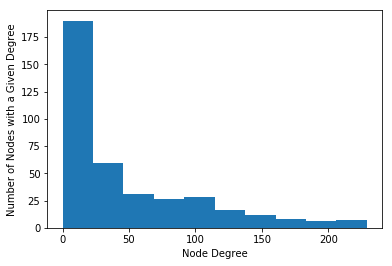

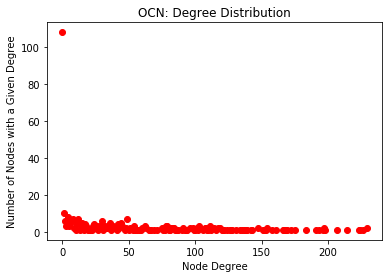

Average Clustering Coefficient: 0.579880317004
grapefruit,malt
celery,prickly_pear
pea,tarragon
fennel,lentil
lime_juice,star_anise
emmental_cheese,artichoke
corn_grit,cucumber
kale,chinese_cabbage
okra,haddock
tamarind,kiwi
PageRank:
butter: 0.01428
wheat: 0.01327
onion: 0.01313
egg: 0.01278
garlic: 0.01245
vegetable_oil: 0.01113
black_pepper: 0.01100
cream: 0.01082
olive_oil: 0.01081
vinegar: 0.01060
['mackerel']
['black_pepper', 'soybean', 'cottage_cheese', 'roasted_sesame_seed', 'tomato_juice', 'turnip', 'sesame_oil', 'garlic', 'goat_cheese', 'watercress', 'tequila', 'cod', 'shiitake', 'beet', 'kelp', 'roasted_beef', 'chervil', 'kale', 'galanga', 'okra', 'caraway', 'thai_pepper', 'root', 'radish', 'sake', 'brassica', 'red_kidney_bean', 'catfish', 'cayenne', 'endive', 'lobster', 'chicken_liver', 'sauerkraut', 'brussels_sprout', 'porcini', 'lima_bean', 'egg_noodle', 'malt', 'enokidake', 'katsuobushi', 'wasabi', 'corn_grit', 'salmon', 'oyster', 'olive_oil', 'vinegar', 'liver', 'chicor

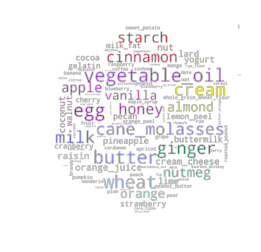



Food Pairing Hypothesis Network Analysis:



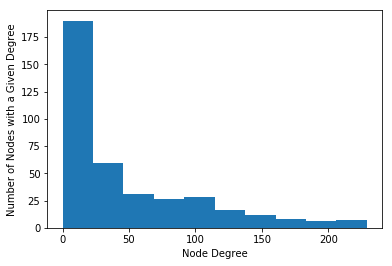

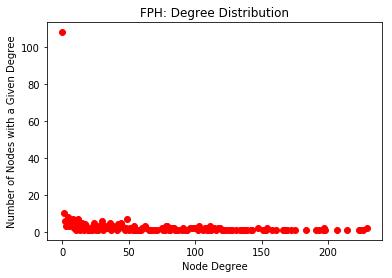

Average Clustering Coefficient: 0.579902206723
tabasco_pepper,fenugreek
butter,chickpea
fennel,beech
roasted_meat,peppermint_oil
tuna,muscat_grape
roasted_pork,black_raspberry
rye_bread,feta_cheese
spearmint,violet
celery_oil,beet
vegetable,muscat_grape
PageRank:
butter: 0.01428
wheat: 0.01327
onion: 0.01314
egg: 0.01278
garlic: 0.01245
vegetable_oil: 0.01113
black_pepper: 0.01100
cream: 0.01082
olive_oil: 0.01081
vinegar: 0.01060
['mackerel']
['black_pepper', 'soybean', 'cottage_cheese', 'roasted_sesame_seed', 'tomato_juice', 'turnip', 'sesame_oil', 'garlic', 'goat_cheese', 'watercress', 'tequila', 'cod', 'shiitake', 'beet', 'kelp', 'roasted_beef', 'chervil', 'kale', 'galanga', 'okra', 'caraway', 'thai_pepper', 'root', 'radish', 'sake', 'brassica', 'red_kidney_bean', 'catfish', 'cayenne', 'endive', 'lobster', 'chicken_liver', 'sauerkraut', 'brussels_sprout', 'porcini', 'lima_bean', 'egg_noodle', 'malt', 'enokidake', 'katsuobushi', 'wasabi', 'corn_grit', 'salmon', 'oyster', 'olive_oil'

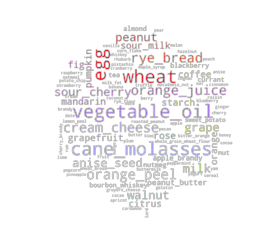



Updated Complement Network Analysis:



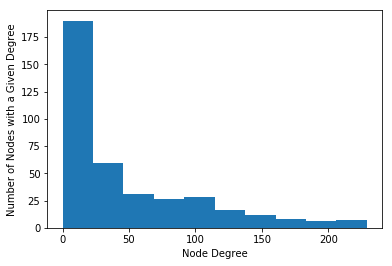

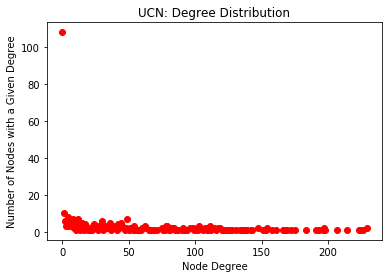

Average Clustering Coefficient: 0.579880317004
chinese_cabbage,lemon
root,pimenta
basil,plum
sour_milk,bone_oil
grape_brandy,chinese_cabbage
cottage_cheese,root
smoked_fish,provolone_cheese
coconut_oil,corn_grit
kale,cognac
quince,cauliflower
PageRank:
butter: 0.01428
wheat: 0.01327
onion: 0.01313
egg: 0.01278
garlic: 0.01245
vegetable_oil: 0.01113
black_pepper: 0.01100
cream: 0.01082
olive_oil: 0.01081
vinegar: 0.01060
['mackerel']
['black_pepper', 'soybean', 'cottage_cheese', 'roasted_sesame_seed', 'tomato_juice', 'turnip', 'sesame_oil', 'garlic', 'goat_cheese', 'watercress', 'tequila', 'cod', 'shiitake', 'beet', 'kelp', 'roasted_beef', 'chervil', 'kale', 'galanga', 'okra', 'caraway', 'thai_pepper', 'root', 'radish', 'sake', 'brassica', 'red_kidney_bean', 'catfish', 'cayenne', 'endive', 'lobster', 'chicken_liver', 'sauerkraut', 'brussels_sprout', 'porcini', 'lima_bean', 'egg_noodle', 'malt', 'enokidake', 'katsuobushi', 'wasabi', 'corn_grit', 'salmon', 'oyster', 'olive_oil', 'vinegar'

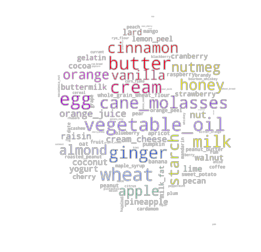



Substitution Network Analysis:



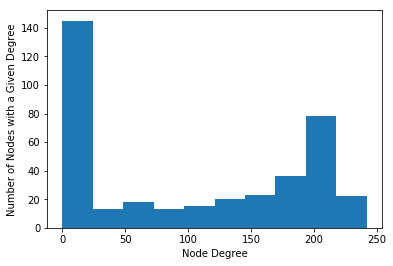

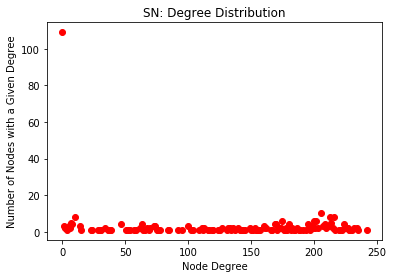

Average Clustering Coefficient: 0.624076785804
octopus,caraway
sunflower_oil,chicken_broth
milk,balm
fennel,rutabaga
roasted_nut,ouzo
beet,pimenta
chayote,kale
kelp,pear_brandy
sweet_potato,blue_cheese
smoke,corn
PageRank:
black_tea: 0.00623
orange: 0.00615
roasted_beef: 0.00589
green_tea: 0.00574
tea: 0.00571
jasmine_tea: 0.00571
raw_beef: 0.00564
beef: 0.00564
strawberry: 0.00553
soybean: 0.00549
['mackerel', 'peanut_butter', 'red_bean', 'almond', 'bacon', 'pecan', 'smoked_sausage', 'honey', 'cottage_cheese', 'orange_juice', 'roasted_sesame_seed', 'bread', 'meat', 'sweet_potato', 'raisin', 'garlic', 'cheddar_cheese', 'tamarind', 'licorice', 'goat_cheese', 'macadamia_nut', 'mung_bean', 'rice', 'sour_milk', 'sheep_cheese', 'yogurt', 'ham', 'cod', 'beef', 'shiitake', 'grapefruit', 'roasted_beef', 'mushroom', 'baked_potato', 'tuna', 'butter', 'okra', 'eel', 'whiskey', 'leek', 'potato', 'milk', 'camembert_cheese', 'pork', 'frankfurter', 'corn', 'radish', 'sake', 'cheese', 'coconut', 'rye_

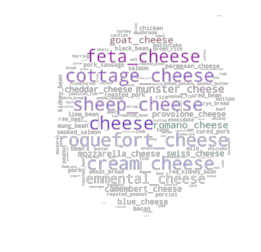

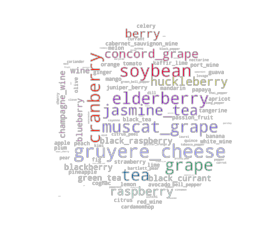



Ingredient Analysis:

Raw Counts:
egg, wheat: 13997
butter, wheat: 13095
butter, egg: 11139
garlic, onion: 9687
milk, wheat: 8550
milk, egg: 8216
butter, milk: 7664
egg, vanilla: 6888
tomato, onion: 6835
garlic, tomato: 6817
wheat, vanilla: 6813
egg, vegetable_oil: 6236
garlic, olive_oil: 6235
butter, vanilla: 6159
garlic, cayenne: 5575
black_pepper, garlic: 5498
black_pepper, onion: 5468
onion, pepper: 5280
butter, cream: 5074
cream, egg: 5033
cayenne, onion: 4915
vegetable_oil, onion: 4817
cream, wheat: 4745
butter, onion: 4738
olive_oil, onion: 4640


FPHF Top Scores:
1. turmeric,fenugreek (0.17395)
2. egg,wheat (0.12492)
3. coriander,fenugreek (0.12073)
4. butter,wheat (0.11125)
5. turmeric,coriander (0.09142)
6. milk,wheat (0.08458)
7. garlic,tomato (0.07490)
8. garlic,olive_oil (0.07369)
9. wheat,vanilla (0.07366)
10. sesame_oil,soy_sauce (0.06988)
11. lavender,savory (0.06667)
12. garlic,cayenne (0.06442)
13. black_pepper,onion (0.06041)
14. cumin,fenugreek (0.05985)
15. egg,v

In [96]:
if __name__ == '__main__':
    analysis()

In [8]:
###############################################
###### Ingredient Comparison Functions ########
###############################################

rid_to_ingredients = Mappings['RID_to_List_of_Ingredients_Mapping']
RIds = rid_to_ingredients.keys()

NIds = [NI.GetId() for NI in IFG.Nodes() if NI.GetId() in IIds]
MedFF = ut.MedFF(IFG, NIds)

def compare(Ingredient1, Ingredient2):
    print 'Comparing {} to {}'.format(Ingredient1, Ingredient2)
    # IIds to test
    AIId = ingredient_to_iid[Ingredient1]
    BIId = ingredient_to_iid[Ingredient2]
    print 'Median Flavor Factor:', MedFF
    FF = ut.JI(IFG, AIId, BIId)
    print 'Flavor Factor:', FF
    RF = ut.JI(IRG, AIId, BIId)
    print 'Recipe Factor:', RF
    FPHF = ut.FPHF(IFG, IRG, AIId, BIId, MedFF)
    print 'FPHF:', FPHF
    COF = ut.COF(IFG, IRG, AIId, BIId, len(RIds), MedFF)
    print 'COF:', COF
    PMI = ut.PMI(IRG, AIId, BIId, len(RIds))
    print 'PMI:', PMI

In [12]:
compare('walnut', 'cashew')
print '\n'

Comparing walnut to cashew
Median Flavor Factor: 0.5
Flavor Factor: 0.347826086957
Recipe Factor: 0.00101591601761
FPHF: (True, 2.3525465436130124e-05)
COF: (True, -1.0513654542064013)
PMI: (True, -1.2035393672498795)


